In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag_Dual(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU((lag+1) * 2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V1, V2):
        #V is shape (batch, 50000, lag+1)
        V = torch.cat([V1, V2], -1)
        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out).reshape(V.shape[0], -1) #(batch*50000,1)
        
        return lin_out

In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda:0")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_dend_interact_0.2ms.npy").reshape(-1,batch_length)
V1 = np.load("/scratch/yjk27/CA1_clust4-60_AP/diff_pred/V_diff_pred_0.2ms.npy").reshape(-1,batch_length)
V2 = np.load("/scratch/yjk27/CA1_clust4-60_AP/nona_pred/V_nona_pred_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V1-= np.mean(V1)
V2-= np.mean(V2)

V1 = torch.from_numpy(V1)
V2 = torch.from_numpy(V2)
S = torch.from_numpy(S)

V1_lag = np.zeros((V1.shape[0], V1.shape[1], lag)) #(lag,1000,50000)
V2_lag = np.zeros((V2.shape[0], V2.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V1_lag[:,i+1:,i] = V1[:,:-i-1]
    V2_lag[:,i+1:,i] = V2[:,:-i-1]

V1_lag = torch.from_numpy(V1_lag)
V2_lag = torch.from_numpy(V2_lag)
print(V1_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V1_train = V1[:980].float()
V1_test = V1[980:].float().to(device)
V2_train = V2[:980].float()
V2_test = V2[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V1_lag_train = V1_lag[:980].float()
V1_lag_test = V1_lag[980:].float().to(device)
V2_lag_train = V2_lag[:980].float()
V2_lag_test = V2_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag_Dual(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

10121


In [6]:
#model.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V.pt",
                     #map_location=device))

In [7]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V1 = V1_train[batch_idx].to(device)
    batch_V1_lag = V1_lag_train[batch_idx].to(device)
    batch_V2 = V2_train[batch_idx].to(device)
    batch_V2_lag = V2_lag_train[batch_idx].to(device)
    
    batch_V1_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V1_in[:,:,0] = batch_V1
    batch_V1_in[:,:,1:] = batch_V1_lag
    batch_V2_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V2_in[:,:,0] = batch_V2
    batch_V2_in[:,:,1:] = batch_V2_lag
    
    S_out = model(batch_V1_in, batch_V2_in)
    loss = torch.mean((S_out - batch_S) ** 2)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V1_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V1_test_in[:,:,0] = V1_test
        V1_test_in[:,:,1:] = V1_lag_test
        V2_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V2_test_in[:,:,0] = V2_test
        V2_test_in[:,:,1:] = V2_lag_test
        
        test_S_out = model(V1_test_in, V2_test_in)
        test_loss = torch.mean((S_test - test_S_out) ** 2)
        test_var_exp = explained_variance_score(S_test.flatten().cpu().detach().numpy(),
                                                test_S_out.flatten().cpu().detach().numpy())
        
        score_list.append(test_loss.item())
        print(i, test_loss.item(), test_var_exp)

<ipython-input-7-99282bbeba95>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 9.797993659973145 0.005494594573974609
49 9.571623802185059 0.027601957321166992
99 9.3362455368042 0.051484644412994385
149 9.069049835205078 0.07864677906036377
199 8.847854614257812 0.1011345386505127
249 8.637946128845215 0.12244278192520142
299 8.94403076171875 0.09143239259719849
349 8.434592247009277 0.1431789994239807
399 8.581268310546875 0.12817740440368652
449 8.434891700744629 0.14307385683059692
499 8.354460716247559 0.1512218713760376
599 8.140935897827148 0.17292475700378418
649 8.075419425964355 0.17957019805908203
699 8.017218589782715 0.1865910291671753
749 8.209565162658691 0.1659407615661621
799 8.025853157043457 0.18464577198028564
849 7.846196174621582 0.20297366380691528
899 7.797162055969238 0.20794862508773804
949 7.821031093597412 0.20541727542877197
999 7.8077239990234375 0.20693296194076538
1049 7.821678161621094 0.20554882287979126
1099 7.746065139770508 0.21304386854171753
1149 7.655871868133545 0.2221977710723877
1199 8.039724349975586 0.183561086654663

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4199 6.945133209228516 0.2944371700286865
4249 6.940084457397461 0.29511117935180664
4299 6.942608833312988 0.2950283885002136
4349 7.113749027252197 0.2781411409378052
4399 6.955050945281982 0.2935277223587036
4449 7.013690948486328 0.2874400019645691
4499 6.995559215545654 0.28932440280914307
4549 7.033124923706055 0.2854718565940857
4599 6.930574893951416 0.2961851954460144
4649 7.05942964553833 0.2829640507698059
4699 6.9340739250183105 0.2957150340080261
4749 7.055408954620361 0.28320056200027466
4799 6.950161933898926 0.2938963770866394
4849 7.069851875305176 0.28228139877319336
4899 7.067295074462891 0.282071053981781
4949 6.912242412567139 0.297745943069458
4999 7.053420066833496 0.2836116552352905
5049 6.942205905914307 0.2947443723678589
5099 7.064181327819824 0.28235363960266113
5149 6.9133124351501465 0.297664999961853
5199 6.91542911529541 0.2974972724914551
5249 7.046791076660156 0.284115195274353
5299 6.954001426696777 0.29350775480270386
5349 7.129106521606445 0.2757416

KeyboardInterrupt: 

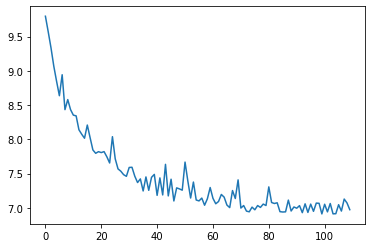

In [8]:
plt.plot(np.asarray(score_list)[:])


tensor(42.7459, device='cuda:0', grad_fn=<MaxBackward1>)


(23000.0, 28000.0)

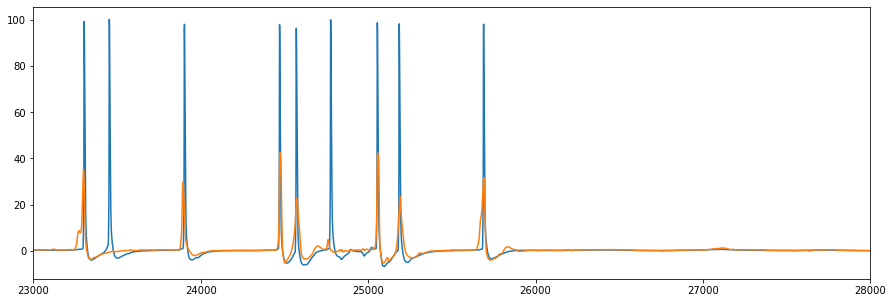

In [9]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[0].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))
plt.xlim(23000,28000)

In [10]:
test_S_out = test_S_out.cpu().detach().numpy()
test_S_out_next = np.zeros_like(test_S_out)
test_S_out_next[:,:-1] = test_S_out[:,1:]
test_S_out_thresh = np.zeros_like(test_S_out)

thresh = 15

for i in range(test_S_out.shape[0]):
    idx = np.where((test_S_out[i] < thresh) & (test_S_out_next[i] >= thresh))[0]
    test_S_out_thresh[i][idx] = 1

In [11]:
print(np.sum(test_S_out_thresh))

167.0


In [11]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_V.pt")

In [12]:
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V.npy", test_S_out)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_S.npy", test_S_out_thresh)